# IEEE Card Fraud Detection

## Contents
1. Load Data
2. Exploratory Data Analysis
3. Building the base model
4. Building the tuned model

## 1. Load Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_id = pd.read_csv("data/train_identity.csv")
train_txn = pd.read_csv("data/train_transaction.csv")

print(f"Shape of train identity: {train_id.shape}")
print(f"Shape of train transaction: {train_txn.shape}")

Shape of train identity: (144233, 41)
Shape of train transaction: (590540, 394)


In [3]:
test_id = pd.read_csv("data/test_identity.csv")
test_txn = pd.read_csv("data/test_transaction.csv")

In [4]:
# primary key is TransactionID
train_df = pd.merge(train_txn,train_id, how = 'left', on = 'TransactionID',validate = "many_to_one")
test_df = pd.merge(test_txn,test_id, how = 'left', on = 'TransactionID',validate = "many_to_one")

In [5]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## 2. Exploratory Data Analysis

In [6]:
import seaborn as sns
import math

In [7]:
fraud_rows = train_df[train_df['isFraud']==1].shape[0]
total_rows = train_df.shape[0]
print(f"{fraud_rows} out of {total_rows} observations were fradulent ({round(fraud_rows/total_rows, 2)}%)")

20663 out of 590540 observations were fradulent (0.03%)


### Transaction Amount

Text(0.5, 1.0, 'Distribution of TransactionAmt')

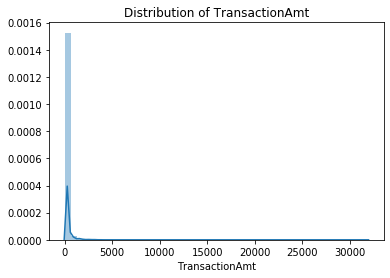

In [8]:
sns.distplot(train_df['TransactionAmt']).set_title('Distribution of TransactionAmt')

Looks like there may be some outliers. Let's take the log of the distribution for a better idea

Text(0.5, 1.0, 'Log Distribution of TransactionAmt')

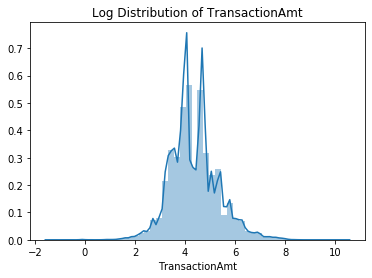

In [9]:
sns.distplot(np.log(train_df['TransactionAmt'])).set_title('Log Distribution of TransactionAmt')

### Transaction Date
Times are reported in seconds (relative)

In [10]:
# Difference between smallest and largest
earliest_day = train_df['TransactionDT'].min() / 86400
latest_day = train_df['TransactionDT'].max() / 86400
print(f"First day in Dataset: {earliest_day}")
print(f"Last day in Dataset: {latest_day}")

First day in Dataset: 1.0
Last day in Dataset: 182.99920138888888


### Product type
Distirbution of the types of products being bought

In [11]:
product_codes = list(train_df['ProductCD'].unique())
print(f"There are {len(product_codes)} product codes: {product_codes}")

There are 5 product codes: ['W', 'H', 'C', 'S', 'R']


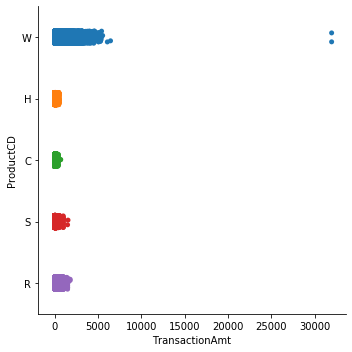

In [12]:
sns.catplot(x="TransactionAmt", y="ProductCD", data=train_df)

Ok, we see the outlier clearly now. Below are these two outliers in detail. Let's remove those rows and plot again for a better representation of the data.

In [13]:
train_df[train_df['TransactionAmt']>20000]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
274336,3261336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274339,3261339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
train_df = train_df[train_df['TransactionAmt']<20000]

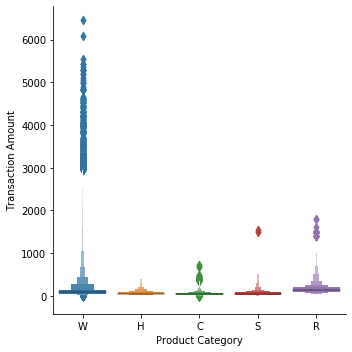

In [15]:
sns.catplot(x="ProductCD", y="TransactionAmt", kind="boxen", data=train_df)\
            .set(xlabel='Product Category', ylabel='Transaction Amount')

In [16]:
product_type_stdev = train_df.groupby('ProductCD').std()['TransactionAmt']
product_type_avg = train_df.groupby('ProductCD').mean()['TransactionAmt']
product_type = pd.DataFrame({"ProductCD": product_type_avg.index,
                             "Mean": list(product_type_avg), 
                             "Stdev": list(product_type_stdev)})

In [17]:
product_type

,ProductCD,Mean,Stdev
0,C,42.872353,38.943070
1,H,73.170058,61.950955
2,R,168.306188,142.035568
3,S,60.269487,80.546775
4,W,153.013971,260.043532


`W` Seems to have a high average due to it being more skewed, confirmed by the high standard deviation. 

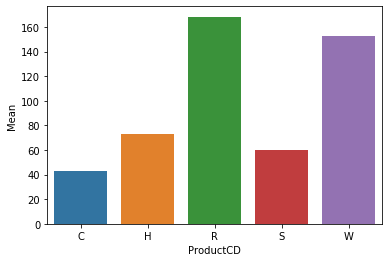

In [18]:
sns.barplot(x="ProductCD", y="Mean", data=product_type)

In terms of average transactions, there are large differences between product categories. Different amounts could influence the likelihood of fradulent transactions occuring due to the nature of certain products.

### Card attributes

In [19]:
card_df = train_df[['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'isFraud']]

#### `card4`: Are certain credit card providers more likely to have fraudulent transactions?

In [20]:
card_df.head()

,card1,card2,card3,card4,card5,card6,isFraud
0,13926,NaN,150.0,discover,142.0,credit,0
1,2755,404.0,150.0,mastercard,102.0,credit,0
2,4663,490.0,150.0,visa,166.0,debit,0
3,18132,567.0,150.0,mastercard,117.0,debit,0
4,4497,514.0,150.0,mastercard,102.0,credit,0


In [21]:
provider_count = card_df.groupby("card4").count()['isFraud']
provider_fraud_count = card_df.groupby("card4").sum()['isFraud']

In [22]:
provider_df = pd.merge(provider_count, provider_fraud_count, on='card4')
provider_df['pctFraud'] = provider_df['isFraud_y'] / provider_df['isFraud_x'] * 100
provider_df

,isFraud_x,isFraud_y,pctFraud
card4,,,
american express,8328,239,2.869837
discover,6651,514,7.728161
mastercard,189215,6496,3.433132
visa,384767,13373,3.475610


#### `card6`: is credit or debit more likely to be fraudulent?

In [23]:
cred_deb = train_df[['card6', 'isFraud']]

debit_fraud = cred_deb[cred_deb['isFraud']==1]['card6'].value_counts()['debit']
credit_fraud = cred_deb[cred_deb['isFraud']==1]['card6'].value_counts()['credit']

debit_total = cred_deb['card6'].value_counts()['debit']
credit_total = cred_deb['card6'].value_counts()['credit']

print(f"There are {debit_fraud} debit fraudulent transactions ({round(debit_fraud/debit_total, 3)})%")
print(f"There are {credit_fraud} credit fraudulent transactions ({round(credit_fraud/credit_total, 3)})%")

There are 10674 debit fraudulent transactions (0.024)%
There are 9950 credit fraudulent transactions (0.067)%


Looks like credit cards are 3 times more likely to have a fraudulent transaction compared to debit cards

### Data Cleaning

In [24]:
# def remove_nans(data):
#     # Find cols with NANs and deal with
#     nans = data.isnull().sum().to_dict()

#     # drop col if more than 40% are NANs
#     threshold = 0.4
#     train_len = data.shape[0]
#     for col, val in nans.items():
#         prop_nan = (val / train_len)
#         if prop_nan >= threshold:
#             data.drop(col, axis=1, inplace=True)
#         elif (prop_nan < threshold) & (val!=0):
#             data[col] = data[col].fillna(-10000) # recommended to set a number outside distribution for catboost
            
#     print(f"Shape of df after removing columns with > {threshold*100}% of values as NANs")
                
#     return data

In [25]:
# train_df_clean = remove_nans(train_df)
train_df_clean = train_df.copy(deep=True)

## Base Model

In [26]:
# Importing the Keras libraries and packages
from sklearn.metrics import auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold

#### Split data

In [27]:
# train_txn = pd.read_csv("data/train_transaction.csv", nrows=10000)
X_train = train_df_clean.drop("isFraud", axis=1)
y_train = train_df_clean["isFraud"]

In [28]:
X_train.shape

(590538, 433)

In [29]:
y_train.shape

(590538,)

#### Remove irrelevant columns

In [30]:
col_to_drop = ['TransactionID']
for col in col_to_drop:
    X_train.drop(col, axis=1, inplace=True)

#### Handle categorical variables
We will onehotencode all categorical data that are strings (e.g. product type), and label encode the rest. `cat_cols` comes from the data description: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-614363

In [31]:
cat_cols = ['ProductCD',
            'card1', 'card2','card3','card4','card5','card6', 
            'addr1', 'addr2', 
            'Pemaildomain', 'Remaildomain', 
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [32]:
cat_cols_to_encode = [col for col in cat_cols if col in list(X_train)]

In [33]:
onehot_cols = [col for col in cat_cols_to_encode if X_train[col].dtype==object]
# Check that the cols for one hot encoding dont have too many unique values (to avoid sparse matrix)
for col in onehot_cols:
    num_unique = len(X_train[col].unique())
    print(f"{col} has {num_unique} unique values")
    
label_cols = [col for col in cat_cols_to_encode if col not in onehot_cols]

ProductCD has 5 unique values
card4 has 5 unique values
card6 has 5 unique values
M1 has 3 unique values
M2 has 3 unique values
M3 has 3 unique values
M4 has 4 unique values
M5 has 3 unique values
M6 has 3 unique values
M7 has 3 unique values
M8 has 3 unique values
M9 has 3 unique values


#### Label encode

In [34]:
def encode_features(data):
    for f in data.columns:
        if data[f].dtype=='object': 
            lbl = LabelEncoder()
            lbl.fit(list(data[f].values))
            data[f] = lbl.transform(list(data[f].values))
    
    print(f"Shape after encoding categorical variables: {data.shape}]")
    
    return data

In [35]:
X_train = encode_features(X_train)

Shape after encoding categorical variables: (590538, 432)]


### Train

In [36]:
import xgboost as xgb

In [37]:
# Check lenggth of x and y
if X_train.shape[0] == y_train.shape[0]:
    print("Number of rows MATCH between x and y")
else:
    print("Number of rows DO NOT MATCH between x and y")

Number of rows MATCH between x and y


In [38]:
base_model = xgb.XGBClassifier(
    n_estimators=300,
#     **best_params,
#     tree_method='gpu_hist'
)

base_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [39]:
# Save model
import pickle
pickle.dump(base_model, open("ieee_fraud_no_drop_nans.pickle", "wb"))

### Validate

In [78]:
from sklearn.metrics import roc_curve
y_pred = base_model.predict_proba(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

NameError: name 'base_model' is not defined

### Test

In [40]:
X_test = encode_features(test_df)

Shape after encoding categorical variables: (506691, 433)]


In [41]:
X_test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.950,4,10409,111.0,150.0,4,226.0,2,...,107,NaN,390,2,2,2,2,2,2,2184
1,3663550,18403263,49.000,4,4272,111.0,150.0,4,226.0,2,...,107,NaN,390,2,2,2,2,2,2,2184
2,3663551,18403310,171.000,4,4476,574.0,150.0,4,226.0,2,...,107,NaN,390,2,2,2,2,2,2,2184
3,3663552,18403310,284.950,4,10989,360.0,150.0,4,166.0,2,...,107,NaN,390,2,2,2,2,2,2,2184
4,3663553,18403317,67.950,4,18018,452.0,150.0,2,117.0,2,...,107,NaN,390,2,2,2,2,2,2,2184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679,0,13832,375.0,185.0,2,224.0,2,...,107,NaN,390,2,2,2,2,2,2,2184
506687,4170236,34214287,12.173,0,3154,408.0,185.0,2,224.0,2,...,5,NaN,390,2,0,0,1,0,1,107
506688,4170237,34214326,49.000,4,16661,490.0,150.0,4,226.0,2,...,107,NaN,390,2,2,2,2,2,2,2184
506689,4170238,34214337,202.000,4,16621,516.0,150.0,2,224.0,2,...,107,NaN,390,2,2,2,2,2,2,2184


In [42]:
txn_id_list = X_test['TransactionID']
col_to_drop = ['TransactionID']
for col in col_to_drop:
    X_test.drop(col, axis=1, inplace=True)
    
X_test = X_test[list(X_train)]

In [43]:
y_pred = base_model.predict_proba(X_test)[:,1] 

In [44]:
my_submission = pd.DataFrame({"TransactionID": txn_id_list,
                              "isFraud": y_pred})

In [45]:
my_submission

,TransactionID,isFraud
0,3663549,0.003448
1,3663550,0.007339
2,3663551,0.021096
3,3663552,0.002765
4,3663553,0.007624
...,...,...
506686,4170235,0.023764
506687,4170236,0.060578
506688,4170237,0.010602
506689,4170238,0.018641


In [46]:
my_submission.to_csv("submission_didnt_drop_nans.csv", index=False)

## Feature Engineering
Potential Features
* Time of day compared to normal
* Time between transactions
* If the same transaction was just made/attempted

## Model Training